## Import libraries

In [1]:
import gc
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

## Prepare data for model training

In [2]:
with open("../input/he-pgd-turkey-ham/MathCoThon_Ready_Sandwich.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

del processed_data
gc.collect()

0

In [3]:
cat_cols = [
    "Genes in mother's side",
    'Inherited from father',
    'Maternal gene',
    'Paternal gene',
    'Status',
    'Respiratory Rate (breaths/min)',
    'Heart Rate (rates/min',
    'Follow-up',
    'Gender',
    'Birth asphyxia',
    'Autopsy shows birth defect (if applicable)',
    'Place of birth',
    'Folic acid details (peri-conceptional)',
    'H/O serious maternal illness',
    'H/O radiation exposure (x-ray)',
    'H/O substance abuse',
    'Assisted conception IVF/ART',
    'History of anomalies in previous pregnancies',
    'Birth defects',
    'Blood test result',
    'Parental consent',
    'Test 1','Test 2','Test 3','Test 4','Test 5',
    'Institute Name',
    'Institute Addr',
    'Institute State',
    'Institute Zipcode',
    "No. of previous abortion",
    'Symptom 1','Symptom 2','Symptom 3','Symptom 4','Symptom 5'
]

train_df[cat_cols] = train_df[cat_cols].astype(int)
test_df[cat_cols] = test_df[cat_cols].astype(int)
cat_cols_indices = [train_df.columns.get_loc(col) for col in cat_cols]
print(cat_cols_indices)

[1, 2, 3, 4, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 17, 12, 13, 14, 15, 16, 8, 41, 42, 43, 29, 33, 34, 35, 36, 37]


In [4]:
temp_df = train_df.groupby(['target']).size().reset_index().rename(columns={0:'count'})
total_count = np.sum(temp_df['count'].values)
temp_df['class%'] = (temp_df['count'] / total_count) * 100
lowest_pct = min(temp_df['class%'])
temp_df['class_weight'] = lowest_pct / temp_df['class%']
class_weight = temp_df[['target', 'class_weight']].to_dict()['class_weight']
class_weight

{0: 0.15502555366269166,
 1: 0.019431988041853514,
 2: 0.022916142029715435,
 3: 0.6842105263157895,
 4: 1.0,
 5: 0.05505142165759225,
 6: 0.02893481717011128,
 7: 0.07410423452768729,
 8: 0.03560250391236306}

In [5]:
Xtrain = train_df.loc[:, ~train_df.columns.isin(['target'])].copy()
Ytrain = train_df['target'].copy()
Xtest = test_df.copy()

print(f"Xtrain: {Xtrain.shape} \nYtrain: {Ytrain.shape} \nXtest: {Xtest.shape}")

del train_df
del test_df
gc.collect()

Xtrain: (18047, 791) 
Ytrain: (18047,) 
Xtest: (9465, 791)


20

## Build and validate the model

In [6]:
FOLD = 10
SEEDS = [2020, 2022]

fet_imp = 0
counter = 0
oof_score = 0
y_pred_meta_cb = np.zeros((Xtrain.shape[0], 9))
y_pred_final_cb = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain.values, Ytrain)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = CatBoostClassifier(
            objective='MultiClass',
            eval_metric='MultiClass',
            num_boost_round=5000,
            class_weights=class_weight,
            use_best_model=True,
            learning_rate=0.0102,
            reg_lambda=0.1756,
            bootstrap_type='Poisson',
            subsample=0.948,
            max_depth=10, 
            grow_policy='Lossguide',
            min_data_in_leaf=9, 
            max_leaves=848,
            task_type='GPU',
            verbose=0,
            random_state=(seed+idx)
        )

        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
                  cat_features=cat_cols_indices,
                  early_stopping_rounds=200, verbose=100)

        y_pred = model.predict_proba(val_x)
        y_pred_meta_cb[val] += y_pred
        y_pred_final_cb += model.predict_proba(Xtest)
        
        y_pred = np.array([np.argmax(y_pred, axis=1)]).T
        score = 100 * f1_score(val_y, y_pred, average='macro')
        oof_score += score
        seed_score += score
        fet_imp += model.feature_importances_
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_cb = y_pred_meta_cb / float(len(SEEDS))
y_pred_final_cb = y_pred_final_cb / float(counter)
fet_imp = fet_imp / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

0:	learn: 2.1786827	test: 2.1851834	best: 2.1851834 (0)	total: 487ms	remaining: 40m 36s
100:	learn: 1.3489600	test: 1.6949927	best: 1.6949927 (100)	total: 47.1s	remaining: 38m 5s
200:	learn: 1.0582266	test: 1.5640118	best: 1.5640118 (200)	total: 1m 32s	remaining: 36m 49s
300:	learn: 0.9022682	test: 1.5109236	best: 1.5109236 (300)	total: 2m 14s	remaining: 35m 5s
400:	learn: 0.8065907	test: 1.4847863	best: 1.4847720 (399)	total: 2m 51s	remaining: 32m 44s
500:	learn: 0.7436799	test: 1.4770557	best: 1.4770557 (500)	total: 3m 19s	remaining: 29m 47s
600:	learn: 0.7020478	test: 1.4769120	best: 1.4762417 (573)	total: 3m 39s	remaining: 26m 43s
700:	learn: 0.6750317	test: 1.4800895	best: 1.4762417 (573)	total: 3m 55s	remaining: 24m 2s
bestTest = 1.476241699
bestIteration = 573
Shrink model to first 574 iterations.
Seed-2020 | Fold-0 | OOF Score: 32.95726889687477
0:	learn: 2.1782682	test: 2.1858736	best: 2.1858736 (0)	total: 440ms	remaining: 36m 38s
100:	learn: 1.3484427	test: 1.6992523	best: 1.

In [7]:
np.savez_compressed('./CB_Meta_Features.npz',
                    y_pred_meta_cb=y_pred_meta_cb, 
                    oof_score=oof_score,
                    y_pred_final_cb=y_pred_final_cb)

## Create submission file

In [8]:
test_df = pd.read_csv("../input/predict-generic-disorder/dataset/test.csv")
submit_df = pd.DataFrame()
submit_df['Patient Id'] = test_df['Patient Id']
submit_df['target'] = np.array([np.argmax(y_pred_final_cb, axis=1)]).T

submit_df['target'] = submit_df['target'].map({
    0: "Mitochondrial genetic inheritance disorders//Leber's hereditary optic neuropathy",
    1: 'Mitochondrial genetic inheritance disorders//Leigh syndrome',
    2: 'Mitochondrial genetic inheritance disorders//Mitochondrial myopathy',
    3: "Multifactorial genetic inheritance disorders//Alzheimer's",
    4: 'Multifactorial genetic inheritance disorders//Cancer',
    5: 'Multifactorial genetic inheritance disorders//Diabetes',
    6: 'Single-gene inheritance diseases//Cystic fibrosis',
    7: 'Single-gene inheritance diseases//Hemochromatosis',
    8: 'Single-gene inheritance diseases//Tay-Sachs'
})

submit_df.groupby(['target']).size().reset_index().rename(columns={0:'Count'})

,target,Count
0,Mitochondrial genetic inheritance disorders//L...,860
1,Mitochondrial genetic inheritance disorders//L...,2303
2,Mitochondrial genetic inheritance disorders//M...,1262
3,Multifactorial genetic inheritance disorders//...,97
4,Multifactorial genetic inheritance disorders//...,16
5,Multifactorial genetic inheritance disorders//...,1249
6,Single-gene inheritance diseases//Cystic fibrosis,2066
7,Single-gene inheritance diseases//Hemochromatosis,529
8,Single-gene inheritance diseases//Tay-Sachs,1083


In [9]:
submit_df['Genetic Disorder'] = submit_df['target'].apply(lambda x: x.split('//')[0])
submit_df['Disorder Subclass'] = submit_df['target'].apply(lambda x: x.split('//')[1])
submit_df.drop(['target'], axis=1, inplace=True)
submit_df.head()

,Patient Id,Genetic Disorder,Disorder Subclass
0,PID0x4175,Multifactorial genetic inheritance disorders,Diabetes
1,PID0x21f5,Single-gene inheritance diseases,Hemochromatosis
2,PID0x49b8,Single-gene inheritance diseases,Tay-Sachs
3,PID0x2d97,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x58da,Single-gene inheritance diseases,Cystic fibrosis


In [10]:
submit_df.to_csv("./CB_Submission.csv", index=False)

## Classification Report

In [11]:
def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Paired)
    plt.title('Confusion matrix', fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [12]:
y_pred = np.array([np.argmax(y_pred_meta_cb, axis=1)]).T
print(classification_report(Ytrain, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.43      0.30       587
           1       0.46      0.38      0.42      4683
           2       0.37      0.29      0.32      3971
           3       0.20      0.29      0.24       133
           4       0.20      0.26      0.23        91
           5       0.32      0.36      0.33      1653
           6       0.41      0.42      0.41      3145
           7       0.30      0.46      0.36      1228
           8       0.30      0.33      0.32      2556

    accuracy                           0.36     18047
   macro avg       0.31      0.36      0.33     18047
weighted avg       0.38      0.36      0.36     18047



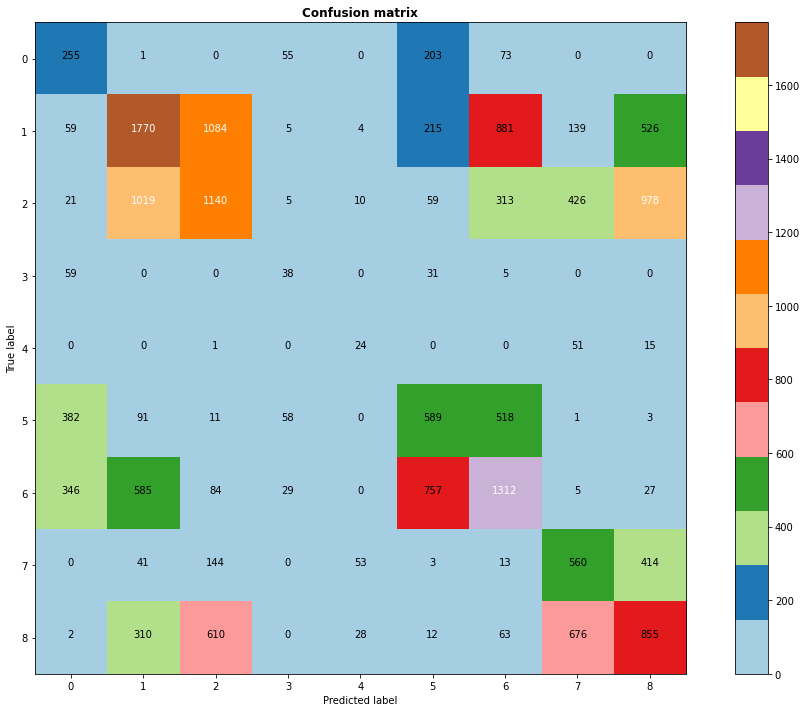

In [13]:
cnf_matrix = confusion_matrix(Ytrain, y_pred, labels=list(range(9)))
np.set_printoptions(precision=2)
plt.figure(figsize=(14,10))
plot_confusion_matrix(cnf_matrix, classes=list(range(9)))

## Features Importance

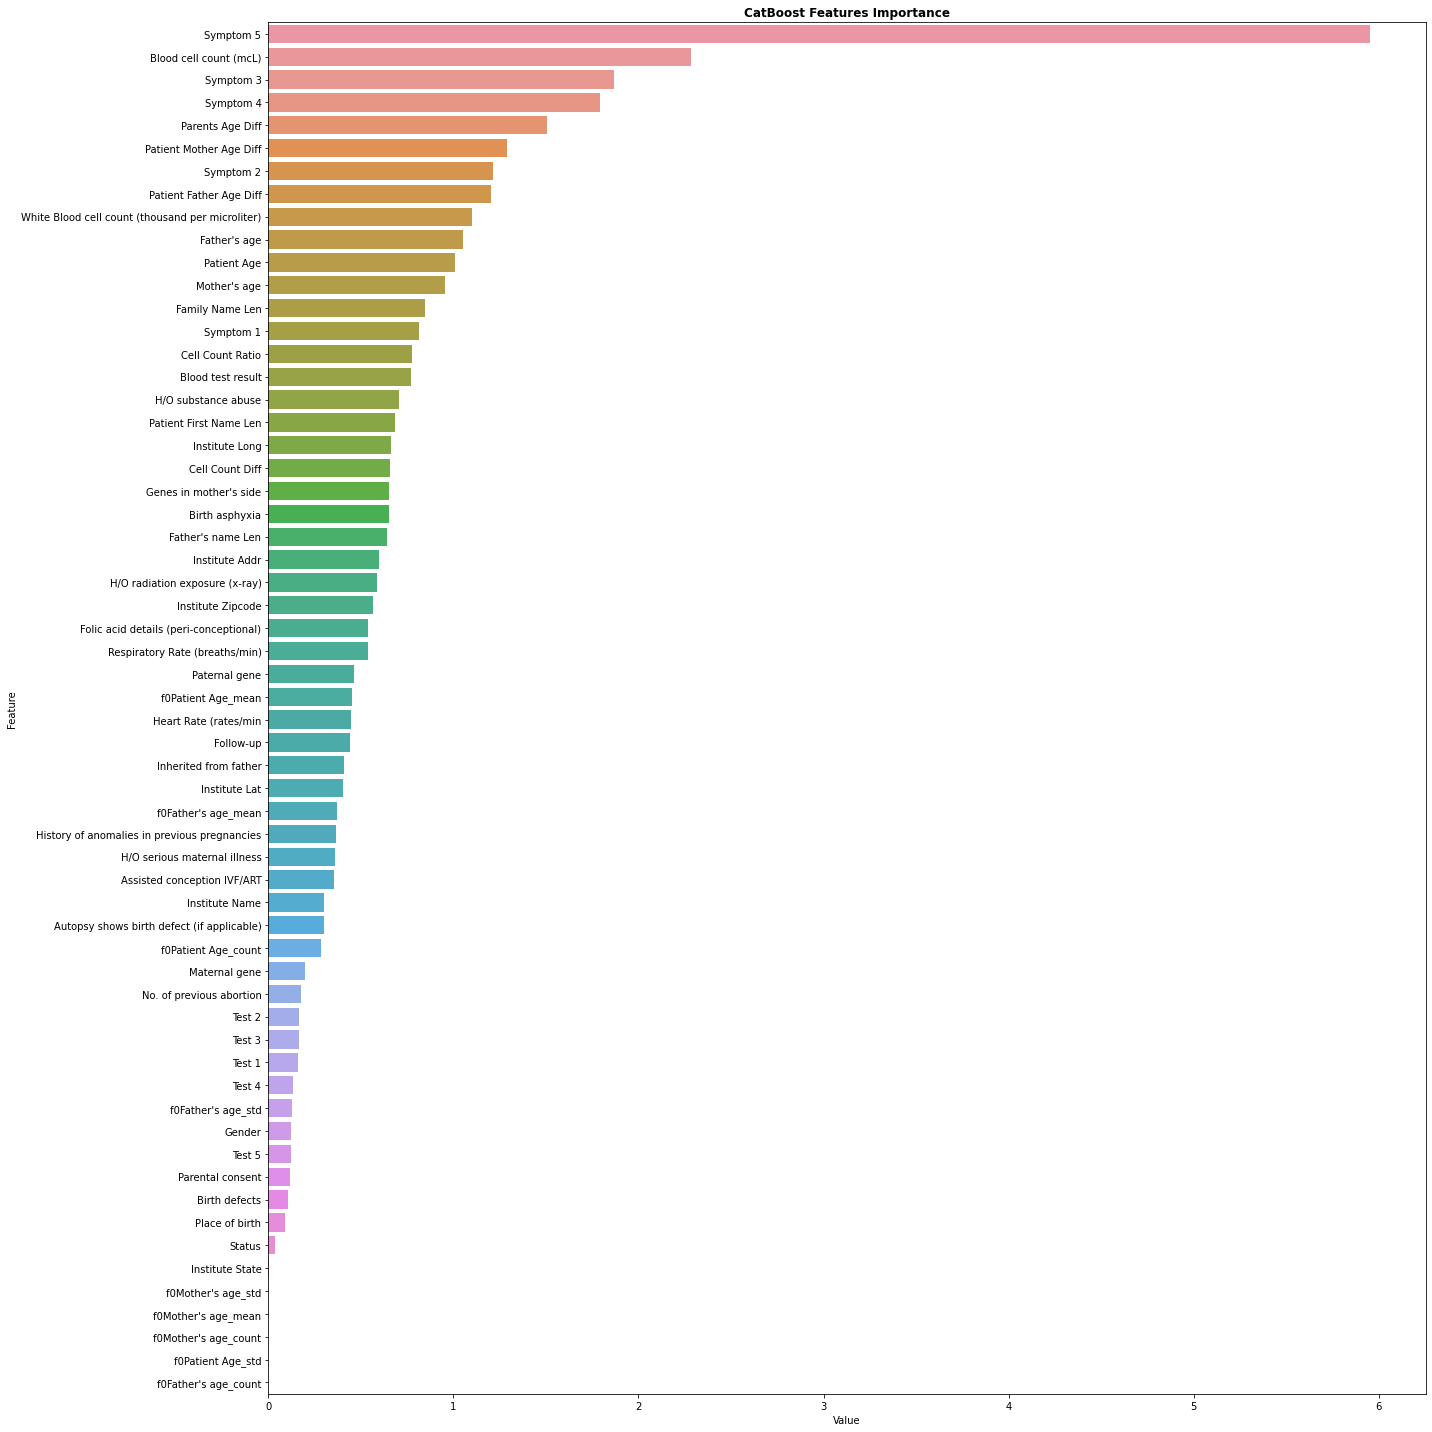

In [14]:
feature_imp = pd.DataFrame(sorted(zip(fet_imp[0:60], Xtrain.columns[0:60])), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('CatBoost Features Importance', fontweight='bold')
plt.tight_layout()
plt.show()